# Space Invader with Poximal Policy Optimization

## Step 1: Import the libraries

In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

from ppo_agent import PPOAgent
from actor_critic_cnn import ActorCnn, CriticCnn

%matplotlib inline

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [2]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
env.seed(0)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


(2968811710, 3677149159)

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment

In [4]:
import cv2

def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

The size of frame is:  (210, 160, 3)
No. of Actions:  6
Action Space:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


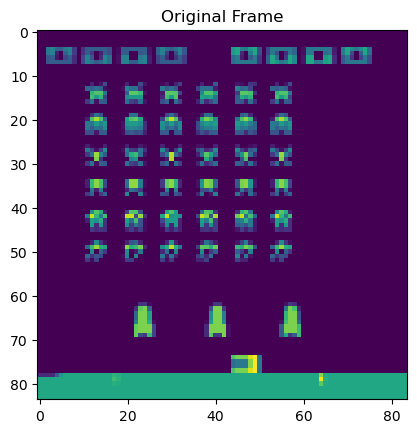

In [5]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
print("Action Space: ", env.unwrapped.get_action_meanings())

initial_frame = env.reset()

# Access the RGB image array from the initial_frame tuple
rgb_image = initial_frame[0]

# Define the cropping parameters and output size
exclude_area = (0, 160, 210, 0)  # Example values, adjust as needed
output_size = 84  # Example value, adjust as needed

# Preprocess the frame
preprocessed_frame = preprocess_frame(rgb_image, exclude_area, output_size)

# Convert the preprocessed frame to a numpy array of type float
frame = np.array(preprocessed_frame, dtype=np.float32)
plt.figure()
plt.imshow(frame)
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play Pong with a random policy.

In [6]:
def random_play():
    score = 0
    env.reset()
    while True:        
        env.render()
        action = env.action_space.sample()
        state, reward, done, _, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

Your Score at end of game is:  45.0


/home/rubensas/anaconda3/envs/MEI_SI/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


## Step 4:Preprocessing Frame

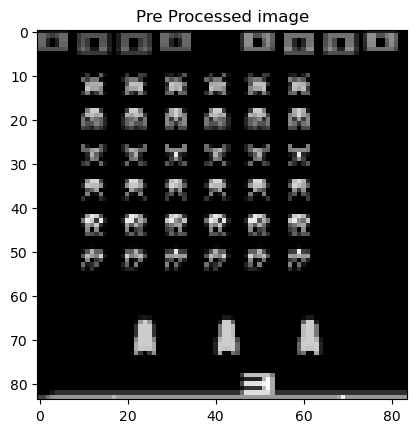

In [7]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset()[0], (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [8]:
def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

In [9]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames    

## Step 6: Creating our Agent

In [10]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0001          # Critic learning rate
TAU = 0.95
BATCH_SIZE = 32
PPO_EPOCH = 5
CLIP_PARAM = 0.2
UPDATE_EVERY = 1000     # how often to update the network 


agent = PPOAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, TAU, UPDATE_EVERY, BATCH_SIZE, PPO_EPOCH, CLIP_PARAM, ActorCnn, CriticCnn)

## Step 7: Watching untrained agent play

In [11]:

# watch an untrained agent
state = stack_frames(None, env.reset()[0], True) 
for j in range(200):
    env.render()
    action, _, _ = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [12]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with PPO

In [13]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset()[0], True)
        score = 0
        while True:
            action, log_prob, value = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, value, log_prob, reward, done, next_state)
            if done:
                break
            else:
                state = next_state
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    return scores

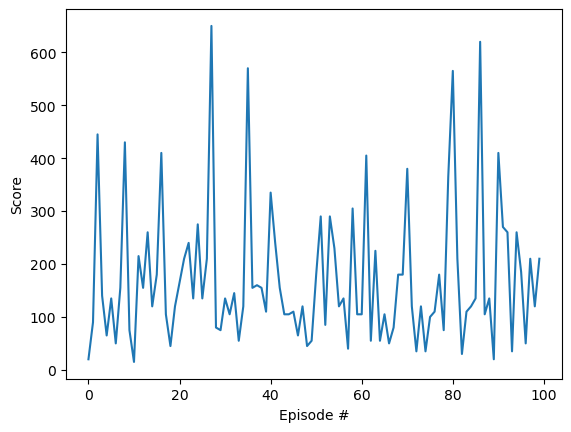

Episode 100	Average Score: 203.00

In [14]:
scores = train(100)

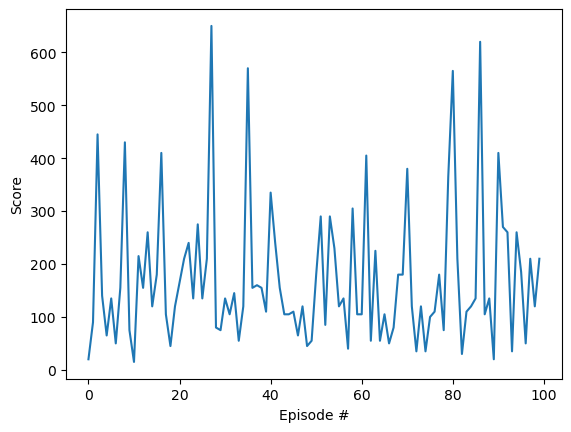

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 10: Watch a Smart Agent!

In [16]:
score = 0
state = stack_frames(None, env.reset()[0], True)
while True:
    env.render()
    action, _, _ = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

You Final score is: 245.0
